# ACC Model Notebook (Done)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data.param_data_loader2 import ParamDL2
dataset = ParamDL2()

# dataset.summarize()

/miniconda/envs/SURE/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Processing Congestion
Processed 24 Congestions
Saved Congestion File
Processing Car Following
Processed 60 cf_events
Saved Car Following File
Datast Loaded. Preview of dataset: 
   driver  trip  congestion  cf_idx  type    time  gmm_n_cluster  \
0       1    53           0       0     0  1698.8              4   
1       1    53           0       0     0  1698.9              4   
2       1    53           0       0     0  1699.0              4   
3       1    53           0       0     0  1699.1              4   
4       1    53           0       0     0  1699.2              4   

   rank_0_cluster  rank_1_cluster  rank_2_cluster  ...  timeHeadway  VL_theta  \
0               2               1               0  ...     2.294240  0.137128   
1               2               1               0  ...     2.304333  0.137128   
2               2               1               0  ...     2.278744  0.138907   
3               2               1               0  ...     2.277959  0.140121   
4       

In [3]:
outlier_seqs = [29, 30, 39, 45]

# Import models, before other cells, so there is no need to rerun some tests
from param_models import *
model = BatchACC(dataset.cf_events, exclude_ids=outlier_seqs, mode='gpu')

In [4]:
import time
# Test using RMSE over Gap
objective = "s_ego_pred_rmsne"

# Simulate and verify that it works
def_params = model.hyperparams.from_default(device=model.device)

# Simulate
t_s = time.perf_counter()
model.simulate(def_params, batch_size=1, pbar=True)
print(f"{model.model_name} simulated in", time.perf_counter()-t_s, "seconds")

# Compute Stats
t_s = time.perf_counter()
stats = model.compute_stats(objective)
print(f"{model.model_name} stats computed in", time.perf_counter()-t_s, "seconds")
print("Baseline parameters produced", objective, "=", stats["overall_"+objective+"_min"])

print(f"Graphing {model.model_name}")
seqs = model.get_seqs(num_samples=0,method="sequential")
model.plot_sim_results(seqs,out_dir="results/"+model.model_name+"_default", label="default", show=False, debug=False)

100%|██████████| 6278/6278 [00:03<00:00, 2083.43it/s]


ACC simulated in 3.0174820909742266 seconds
ACC stats computed in 0.0022984170354902744 seconds
Baseline parameters produced s_ego_pred_rmsne = tensor(0.6217)
Graphing ACC


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


In [5]:
RETUNE = True

# RMSE_best_params = [7.76867867, 1.97889304, 3.29437906, 2.93759704, 5., 4.,  0.6701991 ]  # From a previous tune cycle

# RMSNE
# best_params = [8.4097757,  6.70674908, 1.23848021, 2.43299818,5,4,0.99]
best_params = [ 1.35105629,  1.30290699,  2.22532797,  1.25295256, 13.86810631,  4, 0.99 ]
objective = "s_ego_pred_rmsne"

if RETUNE == True:
    best_params = model.ga_calibrate(objective, sol_size=2048, batch_size=256, num_generations=200)

opt_params = model.hyperparams.from_array(best_params, model.device)
model.simulate(opt_params, batch_size=1)
stats = model.compute_stats(objective)

seqs = model.get_seqs(num_samples=0, method="sequential")
model.plot_sim_results(seqs, out_dir="results/"+model.model_name+"_overall_optimized", label="overall_best", show=False, debug=False)

s_ego_pred_rmsne


Generations Progress:   0%|          | 0/200 [00:00<?, ?it/s]/miniconda/envs/SURE/lib/python3.11/site-packages/pygad/pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
/miniconda/envs/SURE/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


GA Optimizing with batch size 256


Generations Progress: 100%|██████████| 200/200 [9:13:24<00:00, 166.02s/it]  

GA found minimized s_ego_pred_rmsne for ACC at 0.4332296550273895
- Parameters found: [ 1.35105629  1.30290699  2.22532797  1.25295256 13.86810631  4.
  0.99      ]



100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


100%|██████████| 7/7 [13:19<00:00, 114.23s/it]

Plotting Per-Param Optimize Result


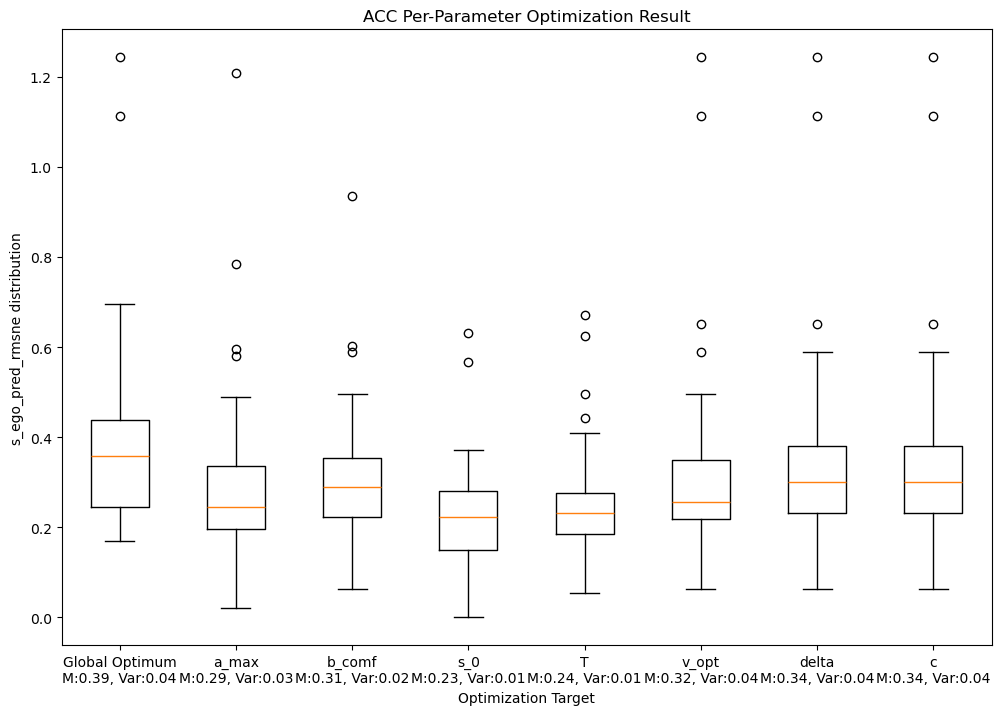

<Figure size 640x480 with 0 Axes>

In [6]:
objective = "s_ego_pred_rmsne"
opt_dict = model.per_param_optimize(best_params, objective)
model.plot_per_param_opt_overview(opt_dict)

In [7]:
model.plot_per_param_opt_indv(opt_dict, best_idx=3)

TypeError: ParamBaseModelBatch.get_seqs() got an unexpected keyword argument 'groups'